In [7]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re


In [8]:
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
}

job_position_id_dict ={
    'frontend_developer' : '669',
    'server_developer' : '872',
    'data_engineer' : '655'
}

def main_crawler(job_position: list, pages=1, years=-1):
    all_results = []
    print("Start_Crawling")
    for position in job_position:
        job_id = job_position_id_dict[position]
        for i in range(pages):
            offset = i * 20
            list_url = f"https://www.wanted.co.kr/api/chaos/navigation/v1/results?job_group_id=518&job_ids={job_id}&country=kr&job_sort=job.popularity_order&years={years}&locations=all&limit=20&offset={offset}"
            
            list_res = requests.get(list_url, headers=headers).json()
            jobs = list_res.get('data', [])
            
            for job in jobs:
                job_id = job.get('id')
                company = job.get('company', {}).get('name')
                job_description = job.get('position')
                
                print(f"  - Collecting [{company}] {job_description} ...")
                
                details = get_job_detail(job_id)
                
                if details:
                    full_info = {
                        'ID': job_id,
                        '회사명': company,
                        '공고명': job_description,
                        **details, 
                        '링크': f"https://www.wanted.co.kr/wd/{job_id}",
                        'position': position,
                    }
                    all_results.append(full_info)
                
                time.sleep(0.5)
            
    df = pd.DataFrame(all_results)
    df.to_csv(f"wanted_developer_jobs.csv", index=False, encoding="utf-8-sig")
    print("finish Crawling")

def get_job_detail(job_id):
    url = f"https://www.wanted.co.kr/api/chaos/jobs/v4/{job_id}/details"
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            res_json = response.json()
            detail = res_json.get('data', {}).get('job', {}).get('detail', {})
            
            return {
                '주요업무': detail.get('main_tasks', ''),
                '자격요건': detail.get('requirements', ''),
                '우대사항': detail.get('preferred_points', ''),
                '복지혜택': detail.get('benefits', '')
            }
    except Exception as e:
        print(f"[Error] ID {job_id}: {e}")
    
    return None


In [9]:
main_crawler(pages=20, years=0, job_position=['data_engineer', 'server_developer', 'frontend_developer'])

Start_Crawling
  - Collecting [클래스유] AI 엔지니어 ...
  - Collecting [업스테이지] [인턴] AI Product Data Management ...
  - Collecting [소크라에이아이] [Socra AI] Data Engineer (신입) ...
  - Collecting [스마일게이트알피지] 언어모델 기반 AI NPC 연구 개발 담당 ...
  - Collecting [렛서] [인턴] AI Engineer ...
  - Collecting [슈퍼센트] 데이터 애널리스트 (마케팅 전략) ...
  - Collecting [디큐랩] 데이터 사이언티스트/엔지니어 (신입 ~ 5년차) ...
  - Collecting [플랜잇스퀘어] SQL Engineer ...
  - Collecting [페이타랩(패스오더)] [주니어] 데이터 엔지니어 (Growth Data Engineer), 서울 ...
  - Collecting [퍼스트해빗] Data Analysis ...
  - Collecting [팀스파르타] [인턴] Data Engineer ...
  - Collecting [퍼스트해빗] ML Research Scientist ...
  - Collecting [잼투인] ARCUS 캐시 응용 개발 ...
  - Collecting [크리스틴컴퍼니] [인턴] AI Engineer (서울) ...
  - Collecting [엘리스] AI 엔지니어 ...
  - Collecting [업스테이지] AI Tech Data Manager ...
  - Collecting [크리스틴컴퍼니] [서울] AI Engineer(3년 이내) ...
  - Collecting [빗썸] Database Engineer (블록체인) ...
  - Collecting [커브컴퍼니] MLOps Engineer (~3년) ...
  - Collecting [애자일소다] AI Software Engineer ...
  - Collecting [케이존

In [14]:
df = pd.read_csv("wanted_developer_jobs.csv")
df.shape[0]

60

In [23]:
def preprocess_text(text):
    if pd.isna(text): 
        return ""
    # preprocessed_text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)
    preprocessed_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    preprocessed_text = re.sub(r'\b[a-zA-Z]\b', ' ', preprocessed_text)
    preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text).strip()
    
    return preprocessed_text


df['combined_text'] = (df['자격요건'].fillna('') + " " + df['우대사항'].fillna('')).apply(preprocess_text)

data_engineer_df = df[df["position"] == 'data_engineer']['combined_text']
server_developer_df = df[df["position"] == 'server_developer']['combined_text']
frontend_developer_df = df[df["position"] == 'frontend_developer']['combined_text']
data_engineer_text = data_engineer_df.dropna().str.cat(sep=" ")
server_developer_text = server_developer_df.dropna().str.cat(sep=" ")
frontend_developer_text = frontend_developer_df.dropna().str.cat(sep=" ")

In [21]:
# 불용어 제거
stopwords_path = "stopwords-ko.txt"
with open(stopwords_path, "r", encoding="utf-8") as f:
    kr_stopwords = set(line.strip() for line in f if line.strip())

# STOPWORDS: wordcloud 라이브러리의 영어 불용어
# kr_stopwords: 한국어 불용어 라이브러리(https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a)
total_stopwords = STOPWORDS | kr_stopwords

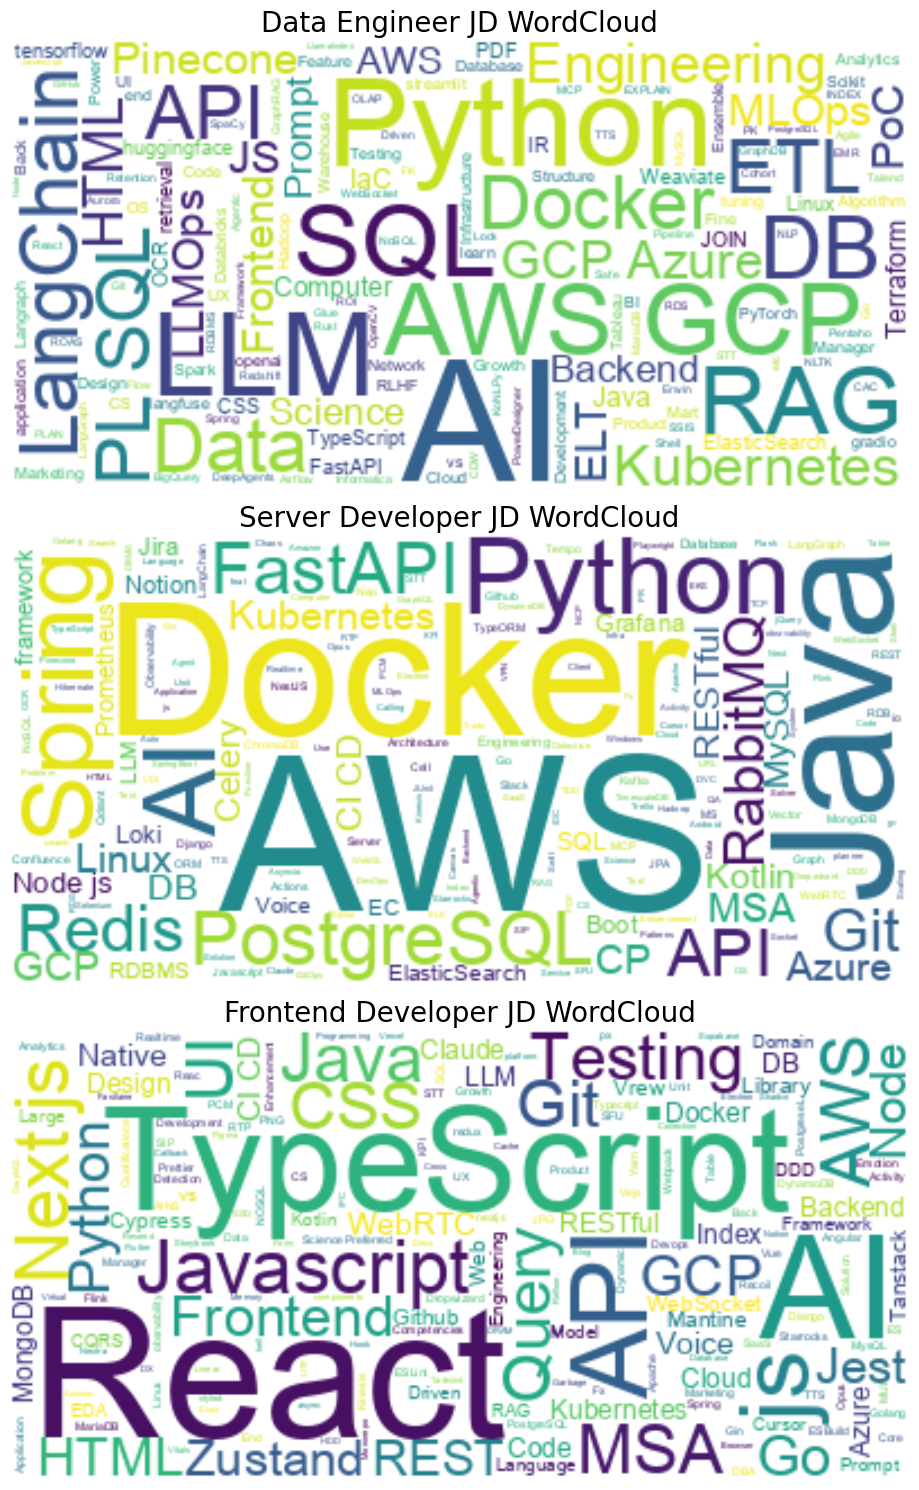

In [24]:
wc_settings = {
    "max_words": 200,
    "background_color": "white",
    "font_path": "/Library/Fonts/Arial Unicode.ttf",
    "stopwords": total_stopwords,
}

data_engineer_wordcloud = WordCloud(**wc_settings).generate(data_engineer_text)
server_wordcloud = WordCloud(**wc_settings).generate(server_developer_text)
frontend_wordcloud = WordCloud(**wc_settings).generate(frontend_developer_text)


plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.imshow(data_engineer_wordcloud, interpolation="bilinear")
plt.title("Data Engineer JD WordCloud", fontsize=20)
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(server_wordcloud, interpolation="bilinear")
plt.title("Server Developer JD WordCloud", fontsize=20)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(frontend_wordcloud, interpolation="bilinear")
plt.title("Frontend Developer JD WordCloud", fontsize=20)
plt.axis("off")


plt.tight_layout()
plt.show()